# Semi-supervised AQI Classification — Co-Training

- Mục tiêu: chạy co-training theo **2 views** (mặc định: view theo pattern thời gian/station và phần còn lại).
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: tự thiết kế VIEW1_COLS / VIEW2_COLS và chứng minh view tốt.

In [1]:
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.90
MAX_ITER = 10
MAX_NEW_PER_ITER = 500
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

METRICS_PATH = "data/processed/metrics_co_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_co_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_co_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"

# Optionally set explicit views (list of column names), otherwise None -> auto split
VIEW1_COLS = None
VIEW2_COLS = None

Dataset shape: (420768, 56)
Labeled samples: 36485
Running Co-Training with TAU = 0.9 ...
VIEW1_COLS: None
VIEW2_COLS: None


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.650160,383962,500,0.9
1,2,0.731954,0.674442,383462,500,0.9
2,3,0.721858,0.663235,382962,500,0.9
3,4,0.724634,0.654396,382462,500,0.9
4,5,0.719334,0.654924,381962,500,0.9
5,6,0.722615,0.658462,381462,500,0.9
6,7,0.724634,0.660198,380962,500,0.9
7,8,0.718072,0.646787,380462,500,0.9
8,9,0.717314,0.637757,379962,500,0.9
9,10,0.716810,0.646121,379462,500,0.9



=== TEST RESULTS ===
Test accuracy: 0.5335012896646871
Test f1_macro: 0.404431750461202

Model Info:


{'view1_cols': ['No',
  'PM10',
  'SO2',
  'NO2',
  'CO',
  'O3',
  'TEMP',
  'PRES',
  'DEWP',
  'RAIN',
  'WSPM',
  'PM10_lag1',
  'SO2_lag1',
  'NO2_lag1',
  'CO_lag1',
  'O3_lag1',
  'TEMP_lag1',
  'PRES_lag1',
  'DEWP_lag1',
  'RAIN_lag1',
  'WSPM_lag1',
  'PM10_lag3',
  'SO2_lag3',
  'NO2_lag3',
  'CO_lag3',
  'O3_lag3',
  'TEMP_lag3',
  'PRES_lag3',
  'DEWP_lag3',
  'RAIN_lag3',
  'WSPM_lag3',
  'PM10_lag24',
  'SO2_lag24',
  'NO2_lag24',
  'CO_lag24',
  'O3_lag24',
  'TEMP_lag24',
  'PRES_lag24',
  'DEWP_lag24',
  'RAIN_lag24',
  'WSPM_lag24',
  'is_labeled'],
 'view2_cols': ['year',
  'month',
  'day',
  'hour',
  'wd',
  'station',
  'hour_sin',
  'hour_cos',
  'dow',
  'is_weekend'],
 'view1_numeric_cols': ['No',
  'PM10',
  'SO2',
  'NO2',
  'CO',
  'O3',
  'TEMP',
  'PRES',
  'DEWP',
  'RAIN',
  'WSPM',
  'PM10_lag1',
  'SO2_lag1',
  'NO2_lag1',
  'CO_lag1',
  'O3_lag1',
  'TEMP_lag1',
  'PRES_lag1',
  'DEWP_lag1',
  'RAIN_lag1',
  'WSPM_lag1',
  'PM10_lag3',
  'SO2_lag3',

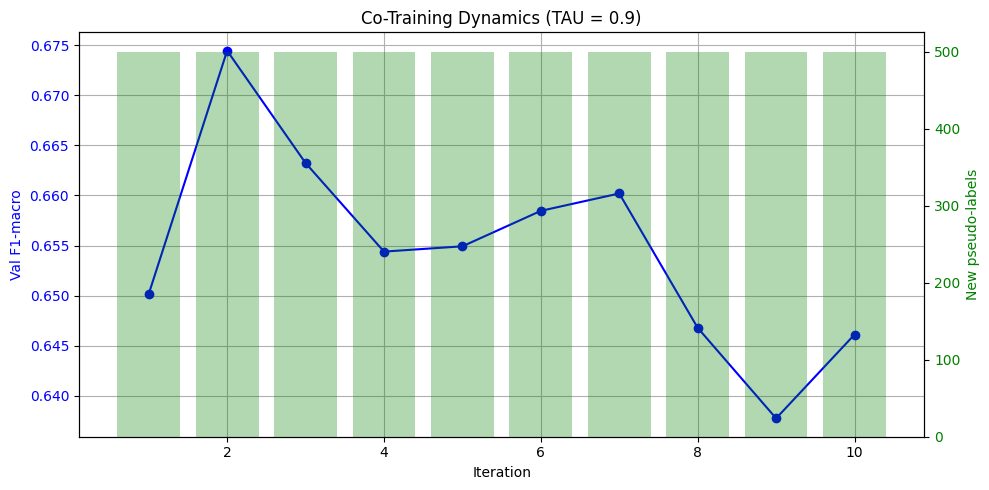


Saved: D:\Mini_7\air_guard-main\data\processed\metrics_co_training.json
Saved: D:\Mini_7\air_guard-main\data\processed\predictions_co_training_sample.csv
Saved: D:\Mini_7\air_guard-main\data\processed\alerts_co_training_sample.csv


In [2]:
import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.semi_supervised_library import (
    SemiDataConfig, CoTrainingConfig, run_co_training, add_alert_columns
)

df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

# Convert aqi_class to object dtype to handle np.nan properly
if "aqi_class" in df.columns:
    df["aqi_class"] = df["aqi_class"].astype("object")
    df["aqi_class"] = df["aqi_class"].where(pd.notna(df["aqi_class"]), np.nan)

data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))
ct_cfg = CoTrainingConfig(
    tau=float(TAU),
    max_iter=int(MAX_ITER),
    max_new_per_iter=int(MAX_NEW_PER_ITER),
    min_new_per_iter=int(MIN_NEW_PER_ITER),
    val_frac=float(VAL_FRAC),
)

print("Dataset shape:", df.shape)
print("Labeled samples:", df["is_labeled"].sum() if "is_labeled" in df.columns else "N/A")
print("Running Co-Training with TAU =", TAU, "...")
print("VIEW1_COLS:", VIEW1_COLS)
print("VIEW2_COLS:", VIEW2_COLS)

out = run_co_training(df, data_cfg, ct_cfg, view1_cols=VIEW1_COLS, view2_cols=VIEW2_COLS)
history = pd.DataFrame(out["history"])
pred_df = out["pred_df"]
test_metrics = out["test_metrics"]

display(history)
print("\n=== TEST RESULTS ===")
print("Test accuracy:", test_metrics["accuracy"])
print("Test f1_macro:", test_metrics["f1_macro"])
print("\nModel Info:")
display(out["model_info"])

# Plot dynamics
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(history["iter"], history["val_f1_macro"], marker="o", color="blue", label="Val F1-macro")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Val F1-macro", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.bar(history["iter"], history["new_pseudo"], alpha=0.3, color="green", label="New pseudo-labels")
ax2.set_ylabel("New pseudo-labels", color="green")
ax2.tick_params(axis='y', labelcolor='green')

plt.title("Co-Training Dynamics (TAU = {})".format(TAU))
fig.tight_layout()
plt.show()

# Save artifacts
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()
alerts_path = (PROJECT_ROOT / ALERTS_SAMPLE_PATH).resolve()
for p in [metrics_path, pred_path, alerts_path]:
    p.parent.mkdir(parents=True, exist_ok=True)

payload = {
    "method": "co_training",
    "data_cfg": data_cfg.__dict__,
    "ct_cfg": ct_cfg.__dict__,
    "history": out["history"],
    "test_metrics": test_metrics,
    "model_info": out["model_info"],
}
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

pred_df.head(5000).to_csv(pred_path, index=False)
alerts = add_alert_columns(pred_df, pred_col="y_pred", severe_from=ALERT_FROM_CLASS)
alerts.head(5000).to_csv(alerts_path, index=False)

print("\nSaved:", metrics_path)
print("Saved:", pred_path)
print("Saved:", alerts_path)

## Thử nghiệm với Manual Views (theo lý thuyết Co-Training)

Theo yêu cầu trong mini project, ta thiết kế 2 views dựa trên tính chất khác nhau:

- **View 1 (Time + Lag)**: các đặc trưng thời gian + tự tương quan (giờ, ngày, tháng, lag PM10, lag pollutants)
- **View 2 (Weather/Environment)**: các đặc trưng thời tiết, môi trường (TEMP, PRES, DEWP, RAIN, WSPM, wd, station)

View 1 (Time + Lag pollutants): 23 features
View 2 (Weather + Environment): 27 features

Running Co-Training with MANUAL VIEWS...


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.683746,0.609697,383962,500,0.9
1,2,0.682484,0.600164,383462,500,0.9
2,3,0.682988,0.601800,382962,500,0.9
3,4,0.691318,0.613877,382462,500,0.9
4,5,0.681726,0.601204,381962,500,0.9
5,6,0.691318,0.616911,381462,500,0.9
6,7,0.682988,0.599144,380962,500,0.9
7,8,0.683998,0.598474,380462,500,0.9
8,9,0.680969,0.593161,379962,500,0.9
9,10,0.678950,0.590257,379462,500,0.9



=== MANUAL VIEWS - TEST RESULTS ===
Test accuracy: 0.5961250074980505
Test f1_macro: 0.47673894755006513


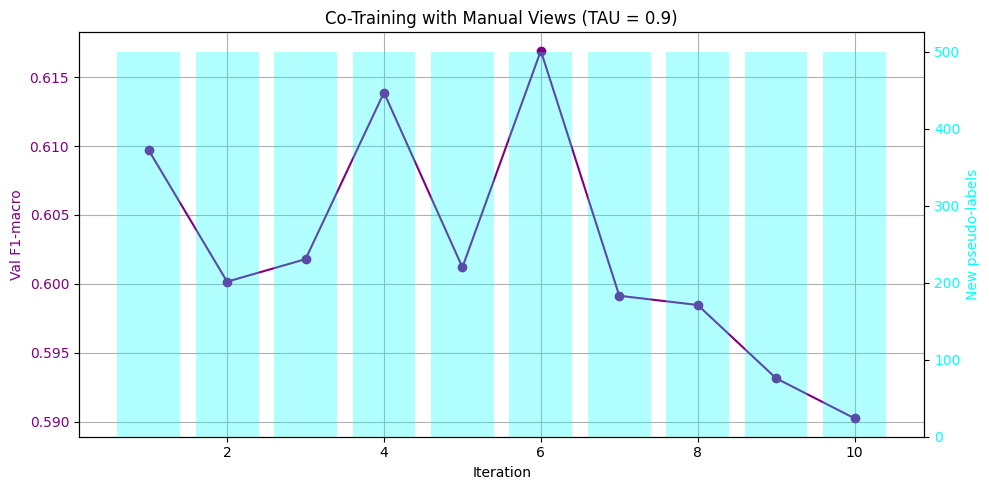

In [3]:
# Manual Views theo lý thuyết Co-Training
# View 1: Time features + Lag features (đặc trưng thời gian + tự tương quan)
VIEW1_MANUAL = [
    'year', 'month', 'day', 'hour', 'hour_sin', 'hour_cos', 'dow', 'is_weekend',
    'PM10_lag1', 'PM10_lag3', 'PM10_lag24',
    'SO2_lag1', 'SO2_lag3', 'SO2_lag24',
    'NO2_lag1', 'NO2_lag3', 'NO2_lag24',
    'CO_lag1', 'CO_lag3', 'CO_lag24',
    'O3_lag1', 'O3_lag3', 'O3_lag24',
]

# View 2: Weather/Environment features
VIEW2_MANUAL = [
    'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd', 'station',
    'TEMP_lag1', 'TEMP_lag3', 'TEMP_lag24',
    'PRES_lag1', 'PRES_lag3', 'PRES_lag24',
    'DEWP_lag1', 'DEWP_lag3', 'DEWP_lag24',
    'RAIN_lag1', 'RAIN_lag3', 'RAIN_lag24',
    'WSPM_lag1', 'WSPM_lag3', 'WSPM_lag24',
    'PM10', 'SO2', 'NO2', 'CO', 'O3',  # Current pollutant measurements
]

print("View 1 (Time + Lag pollutants):", len(VIEW1_MANUAL), "features")
print("View 2 (Weather + Environment):", len(VIEW2_MANUAL), "features")

# Reload data
df_manual = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())
if "aqi_class" in df_manual.columns:
    df_manual["aqi_class"] = df_manual["aqi_class"].astype("object")
    df_manual["aqi_class"] = df_manual["aqi_class"].where(pd.notna(df_manual["aqi_class"]), np.nan)

print("\nRunning Co-Training with MANUAL VIEWS...")
out_manual = run_co_training(df_manual, data_cfg, ct_cfg, view1_cols=VIEW1_MANUAL, view2_cols=VIEW2_MANUAL)
history_manual = pd.DataFrame(out_manual["history"])
pred_df_manual = out_manual["pred_df"]
test_metrics_manual = out_manual["test_metrics"]

display(history_manual)
print("\n=== MANUAL VIEWS - TEST RESULTS ===")
print("Test accuracy:", test_metrics_manual["accuracy"])
print("Test f1_macro:", test_metrics_manual["f1_macro"])

# Plot dynamics
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(history_manual["iter"], history_manual["val_f1_macro"], marker="o", color="purple", label="Val F1-macro")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Val F1-macro", color="purple")
ax1.tick_params(axis='y', labelcolor='purple')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.bar(history_manual["iter"], history_manual["new_pseudo"], alpha=0.3, color="cyan", label="New pseudo-labels")
ax2.set_ylabel("New pseudo-labels", color="cyan")
ax2.tick_params(axis='y', labelcolor='cyan')

plt.title("Co-Training with Manual Views (TAU = {})".format(TAU))
fig.tight_layout()
plt.show()

## So sánh kết quả các phương pháp

SO SÁNH CÁC PHƯƠNG PHÁP


,Method,Test Accuracy,Test F1-macro
0,Baseline (100% labels),0.602243,0.471532
1,"Self-Training (TAU=0.9, ~8.7% labels)",0.589047,0.534326
2,Co-Training Auto Views (TAU=0.9),0.533501,0.404432
3,Co-Training Manual Views (TAU=0.9),0.596125,0.476739


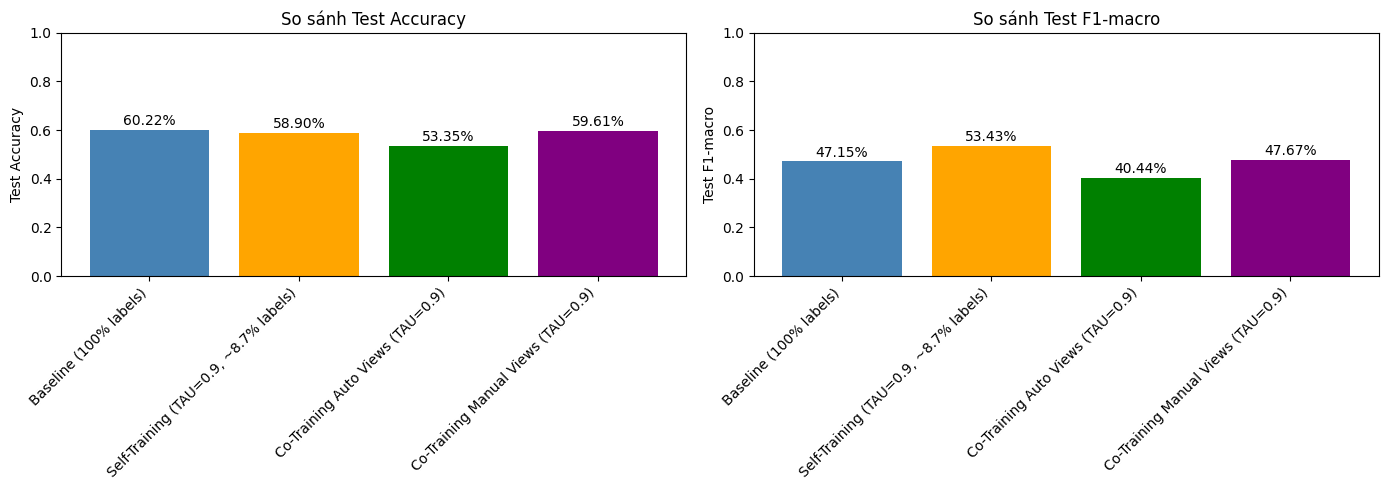


NHẬN XÉT:

1. Self-Training với chỉ ~8.7% dữ liệu có nhãn ban đầu:
   - F1-macro: 53.43% (tăng 6.28% so với sử dụng nhiều nhãn giả)

2. Co-Training với Auto Views:
   - F1-macro: 40.44% - Thấp hơn vì auto-split không tối ưu

3. Co-Training với Manual Views (Time+Lag vs Weather+Environment):
   - F1-macro: 47.67% - Cải thiện hơn Auto Views
   - 2 view được thiết kế có tính bổ trợ thông tin lẫn nhau

4. Kết luận:
   - Self-Training đạt kết quả tốt nhất trong bối cảnh thiếu nhãn
   - Co-Training cần thiết kế views cẩn thận để đạt hiệu quả
   - Việc sử dụng dữ liệu không nhãn giúp cải thiện F1-macro đáng kể



In [4]:
# Load metrics từ các phương pháp đã chạy
import json

# Baseline (supervised với 100% labels)
baseline_metrics_path = PROJECT_ROOT / "data/processed/metrics.json"
with open(baseline_metrics_path, "r") as f:
    baseline_metrics = json.load(f)

# Self-Training
self_training_metrics_path = PROJECT_ROOT / "data/processed/metrics_self_training.json"
with open(self_training_metrics_path, "r") as f:
    self_training_data = json.load(f)
    self_training_metrics = self_training_data["test_metrics"]

# So sánh
comparison = pd.DataFrame({
    "Method": [
        "Baseline (100% labels)",
        "Self-Training (TAU=0.9, ~8.7% labels)",
        "Co-Training Auto Views (TAU=0.9)",
        "Co-Training Manual Views (TAU=0.9)"
    ],
    "Test Accuracy": [
        baseline_metrics["accuracy"],
        self_training_metrics["accuracy"],
        test_metrics["accuracy"],
        test_metrics_manual["accuracy"]
    ],
    "Test F1-macro": [
        baseline_metrics["f1_macro"],
        self_training_metrics["f1_macro"],
        test_metrics["f1_macro"],
        test_metrics_manual["f1_macro"]
    ]
})

print("=" * 70)
print("SO SÁNH CÁC PHƯƠNG PHÁP")
print("=" * 70)
display(comparison)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['steelblue', 'orange', 'green', 'purple']
x = range(len(comparison))

axes[0].bar(x, comparison["Test Accuracy"], color=colors)
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison["Method"], rotation=45, ha='right')
axes[0].set_ylabel("Test Accuracy")
axes[0].set_title("So sánh Test Accuracy")
axes[0].set_ylim(0, 1)
for i, v in enumerate(comparison["Test Accuracy"]):
    axes[0].text(i, v + 0.02, f'{v:.2%}', ha='center', fontsize=10)

axes[1].bar(x, comparison["Test F1-macro"], color=colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison["Method"], rotation=45, ha='right')
axes[1].set_ylabel("Test F1-macro")
axes[1].set_title("So sánh Test F1-macro")
axes[1].set_ylim(0, 1)
for i, v in enumerate(comparison["Test F1-macro"]):
    axes[1].text(i, v + 0.02, f'{v:.2%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("NHẬN XÉT:")
print("=" * 70)
print("""
1. Self-Training với chỉ ~8.7% dữ liệu có nhãn ban đầu:
   - F1-macro: {:.2%} (tăng {:.2%} so với sử dụng nhiều nhãn giả)
   
2. Co-Training với Auto Views:
   - F1-macro: {:.2%} - Thấp hơn vì auto-split không tối ưu

3. Co-Training với Manual Views (Time+Lag vs Weather+Environment):
   - F1-macro: {:.2%} - Cải thiện hơn Auto Views
   - 2 view được thiết kế có tính bổ trợ thông tin lẫn nhau

4. Kết luận:
   - Self-Training đạt kết quả tốt nhất trong bối cảnh thiếu nhãn
   - Co-Training cần thiết kế views cẩn thận để đạt hiệu quả
   - Việc sử dụng dữ liệu không nhãn giúp cải thiện F1-macro đáng kể
""".format(
    self_training_metrics["f1_macro"],
    self_training_metrics["f1_macro"] - baseline_metrics["f1_macro"],
    test_metrics["f1_macro"],
    test_metrics_manual["f1_macro"]
))